In [28]:
import sys

import matplotlib.pyplot as plt
import numpy as np

if '../' not in sys.path:
    sys.path.append('../')
import visualize_main as vm

## Prepare Results

In [33]:
roc_scores = {'DEATH 60+ (1y)': [0.79232, 0.84539, 0.84615, 0.84688, 0.84206, 0.84595, 0.85567, 0.85687, 0.8562, 0.85706, 0.85208, 0.85914], 'PAIN (1m)': [0.76528, 0.77013, 0.7774, 0.77874, 0.77797, 0.78124, 0.78481, 0.78502, 0.78478, 0.78739, 0.78226, 0.78749], 'INFECTION (1w)': [0.72669, 0.73867, 0.74367, 0.74341, 0.74373, 0.74366, 0.75124, 0.75201, 0.75384, 0.75493, 0.74723, 0.75696]}
roc_stds = {'DEATH 60+ (1y)': [0.00133, 0.00149, 0.00055, 0.00169, 0.00174, 0.00159, 0.00106, 0.0011, 0.00126, 0.00145, 0.00197, 0.00136], 'PAIN (1m)': [0.00073, 0.00131, 0.00079, 0.00063, 0.00021, 0.00036, 0.00062, 0.00045, 0.00054, 0.00106, 0.00024, 0.00084], 'INFECTION (1w)': [0.00105, 0.00065, 0.001, 0.00041, 0.00069, 0.00186, 0.00073, 0.001, 0.00084, 0.00114, 0.00122, 0.00101]}
def rename_tasks(scores: dict, task_rename:dict)-> dict:
    new_scores = {}
    for key in scores.keys():
        new_key = task_rename[key]
        new_scores[new_key] = scores[key]
    return new_scores
task_rename = {
    'DEATH 60+ (1y)': 'Death 60+ (1 yr.)',
    'PAIN (1m)': 'Pain\nTreatment (1 mo.)',
    'INFECTION (1w)': 'General\nInfection (1 wk.)',
}
roc_scores= rename_tasks(roc_scores, task_rename)   
roc_stds = rename_tasks(roc_stds, task_rename)


roc_scores['average'] = [np.mean([roc_scores[key][i] for key in roc_scores.keys() if roc_scores[key][i] is not None])\
                          for i in range(len(roc_scores['Death 60+ (1 yr.)']))]
roc_stds['average'] = [np.sqrt(np.mean([roc_stds[key][i]**2 for key in roc_stds.keys() if roc_stds[key][i] is not None]))\
                        for i in range(len(roc_stds['Death 60+ (1 yr.)']))]

models = ['medbert_001_diag', '001_diag', '001', '111', '110', '111_no_binarysegments', 
          '111_time2vec_abspos', '111_t2v_AgeAbspos_avg', '111_t2v_AgeAbspos_++_avg', 
          '111_t2v_AgeAbspos_++_MRR20', '111_t2v_AgeAbspos_++_MRR20_PLOS', '111_t2v_AgeAbspos_++_MRR20_BiGRU']
model_map = {
    'medbert_001_diag':'MedBERT diag', 
    '001_diag':'BEHRT', '001':'+Medication', '111':'+Full Codes\n+Sex', '110':r'$-$'+'SEP'+'\nToken',
    '111_posirang':'+pos_ids', '111_++':'transformer++',
    '111_time2vec_abspos':'+t2v(timestamps)',
    '111_Abspos++':'t2v(ts)\n+transformer++',
    '111_t2v_AgeAbspos_avg':'+t2v(age)*',
    '111_11':'trainable\nembedding\nweights',
    '111_t2v_AgeAbspos_++_avg':'+RoPE\n+SwiGLU*',
    '111_t2v_AgeAbspos_++_MRR10':'MRR10',
    '111_t2v_AgeAbspos_++_MRR20':'Masking\nRatio 20%',
    '111_t2v_AgeAbspos_++_MRR25':'MRR25',
    '111_t2v_AgeAbspos_++_MRR30':'MRR30',
    '111_t2v_AgeAbspos_++_MRR20_PLOS':'+Prolonged\nLOS',
    '111_t2v_AgeAbspos_++_MRR20_Attention':'Attention-Weighted\nMean',
    '111_t2v_AgeAbspos_++_MRR20_Mean':'Mean',
    '111_t2v_AgeAbspos_++_MRR20_BiGRU':'BiGRU',
    '111_no_binarysegments':'Simplified\nSegments',

             }
inv_model_map = {v:k for k,v in model_map.items()}

# models = [model_map[model] for model in models]
model_groups = {
    'Data': ['BEHRT', '+Medication', '+Full Codes\n+Sex',r'$-$'+'SEP'+'\nToken', 'Simplified\nSegments','+t2v(timestamps)',],
    'Model': ['+t2v(age)*',
            #'trainable\nembedding\nweights',
            '+RoPE\n+SwiGLU*',
                ], 
    'Training': [ 'Masking\nRatio 20%', '+Prolonged\nLOS','BiGRU']
}
def get_scores(model_groups, original_models, scores):
    new_scores = {disease: [] for disease in scores.keys()}
    for group, new_models in model_groups.items():
        for model in new_models:
            original_model = inv_model_map[model]
            model_index = original_models.index(original_model)
            for key in scores.keys():
                new_scores[key].append(scores[key][model_index])

    return new_scores
#
#Specify which models should be hatched
n_data = len(model_groups['Data'])
n_model = len(model_groups['Model'])
n_training = len(model_groups['Training'])
groups = {
    'Data': slice(0, n_data),
    'Model': slice(n_data, n_data+n_model),
    'Training': slice(n_data+n_model, n_data+n_model+n_training)
}
roc_scores = get_scores(model_groups, models,  roc_scores)
roc_stds = get_scores(model_groups, models,  roc_stds)
model_adapted = [True] * 3 +  [False] + [True]*5 + [False]+ [True]
models = [model for group in model_groups.values() for model in group]
print('len model adapted', len(model_adapted))
print('len models', len(models))
assert len(model_adapted) == len(models) 
for key in roc_scores.keys():
    assert len(roc_scores[key]) == len(models)
    assert len(roc_stds[key]) == len(models)


len model adapted 11
len models 11


(0.78473, 0.7972400000000001, 0.8011966666666667)

## Final Figure

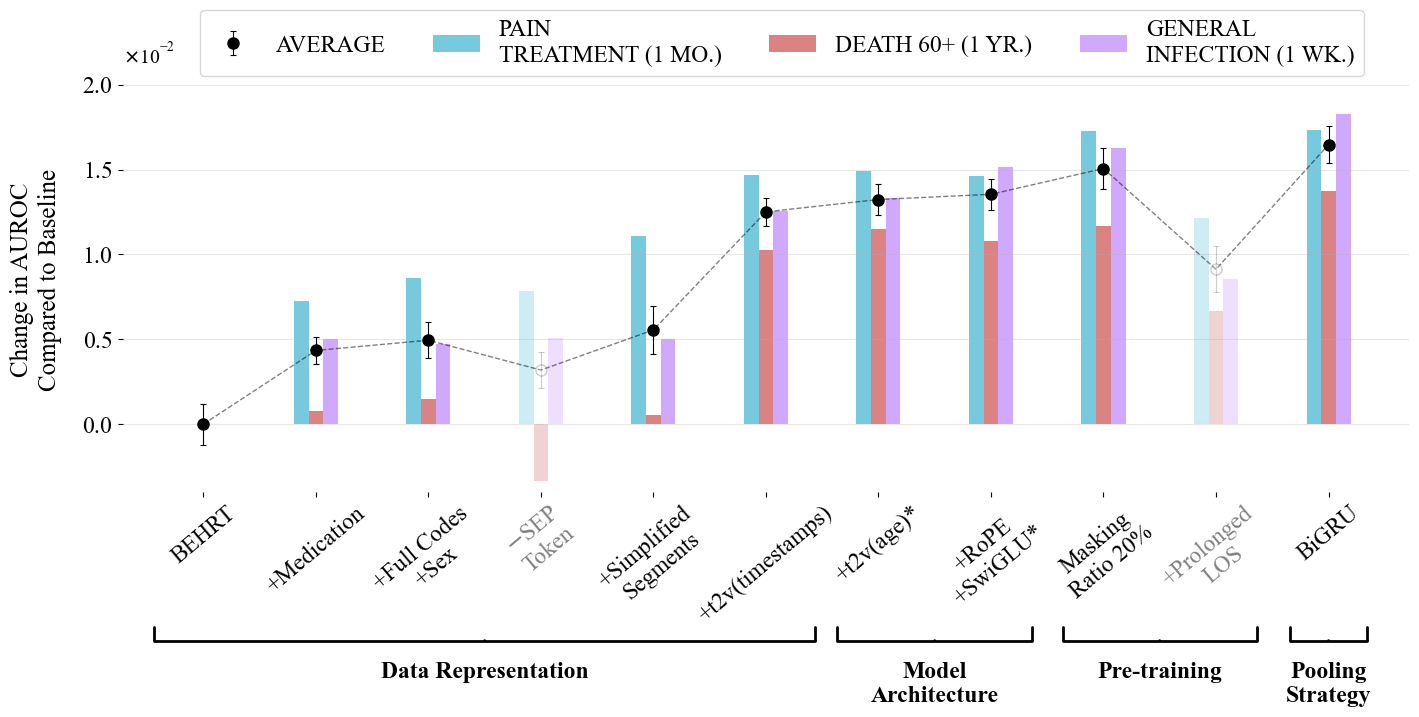

In [32]:
import importlib
importlib.reload(vm)
plt.rcParams['font.family'] = "Times New Roman"
FIGSIZE = (15, 8)
MODEL_DISTANCE = 0.15
GROUP_GAP = 0.0
LEGEND_LOC = (0.06, .98)
GROUP_LABEL_PAD = 0.01
Y_LIM = (-.004, .021)
GROUP_LABEL_FS = 17
# BOX_COLORS = {'Data': "#5599FF", 'Model': "#5599FF", 'Training': "#5599FF"}
FONTSIZE1 = 17
FONTSIZE2 = 18
Y_POS_BRACKET = -.35
GROUP_ANNOTATION_DISTANCE = 0.05
colors = { 'average':'k','Pain\nTreatment (1 mo.)': '#07A0C3', 'Death 60+ (1 yr.)': '#BD1E1E','General\nInfection (1 wk.)': '#AB63FA', }

def main():
    # Your data initialization here
    fig, ax = plt.subplots(figsize=FIGSIZE)
    adjusted_positions, _, _ = vm.initialize_plot(models, groups, MODEL_DISTANCE, GROUP_GAP)
    vm.plot_data(ax, adjusted_positions, model_adapted, roc_scores, roc_stds, colors, MODEL_DISTANCE)

    # Setting the x-ticks to be the diseases with adjusted positions
    ax.set_xticks(adjusted_positions + MODEL_DISTANCE*2)
    ax.set_xticklabels(models, fontsize=FONTSIZE1, rotation=40, color='k')
    vm.set_model_adapted_colors(ax, model_adapted)

    ax.set_ylim(Y_LIM)
    y_ticklabels = [0, .005, .01, .015,.02
                    ]
    vm.style_plot(ax, y_ticklabels, FONTSIZE1, LEGEND_LOC)    
    ax.set_ylabel('Change in AUROC\nCompared to Baseline', fontsize=FONTSIZE2, color='k',labelpad=15)

    distance_between_models = adjusted_positions[1] - adjusted_positions[0]
    center_data = adjusted_positions[2]+MODEL_DISTANCE*2+distance_between_models/2
    vm.add_bracket_with_text(ax, center_data, 17, Y_POS_BRACKET, text='Data Representation', fontsize=GROUP_LABEL_FS, annotation_distance=GROUP_ANNOTATION_DISTANCE)
  
    center_data = adjusted_positions[6]+MODEL_DISTANCE*2+distance_between_models/2
    vm.add_bracket_with_text(ax, center_data, 5, Y_POS_BRACKET, text='Model\nArchitecture', fontsize=GROUP_LABEL_FS, annotation_distance=GROUP_ANNOTATION_DISTANCE)
    
    center_data = adjusted_positions[8]+MODEL_DISTANCE*2+distance_between_models/2
    vm.add_bracket_with_text(ax, center_data, 5, Y_POS_BRACKET, text='Pre-training', fontsize=GROUP_LABEL_FS, annotation_distance=GROUP_ANNOTATION_DISTANCE)
    
    
    center_data = adjusted_positions[8]+MODEL_DISTANCE*2+distance_between_models/2
    
    
    center_data = adjusted_positions[10]+MODEL_DISTANCE*2
    vm.add_bracket_with_text(ax, center_data, 2, Y_POS_BRACKET, text='Pooling\nStrategy', fontsize=GROUP_LABEL_FS, annotation_distance=GROUP_ANNOTATION_DISTANCE)
    
    plt.tight_layout()
    plt.show()

    fig.savefig('../../results/roc_scores_comparison.png', dpi=300, bbox_inches='tight')

if __name__ == "__main__":
    main()


P values

In [31]:
roc_scores['average'][0], roc_scores['average'][5], roc_scores['average'][-1]
from statsmodels.stats.multitest import multipletests
import numpy as np
from scipy.stats import t

# Sample size for each mean/std (from 5 measurements)
def get_p_values(mean_base, std_base, mean_best, std_best, N=10, n=12):
    mean_diff = mean_best - mean_base
    se_diff = np.sqrt((std_base**2 / N) + (std_best**2 / N))  # Standard error of the mean difference
    t_stat = mean_diff / se_diff  # t-statistic
    p_value = t.sf(np.abs(t_stat), df=n-1)  # one-sided p-value
    return p_value
n = 3
means = roc_scores['average']
stds = roc_stds['average']
# Calculate t-statistics and p-values for each comparison against baseline
p_values = []
for i in range(1, len(means)):
    # Standard error for each group mean
    p_values.append(get_p_values(means[0], stds[0], means[i], stds[i], N=n))

adjusted_p_values = multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

## Figure

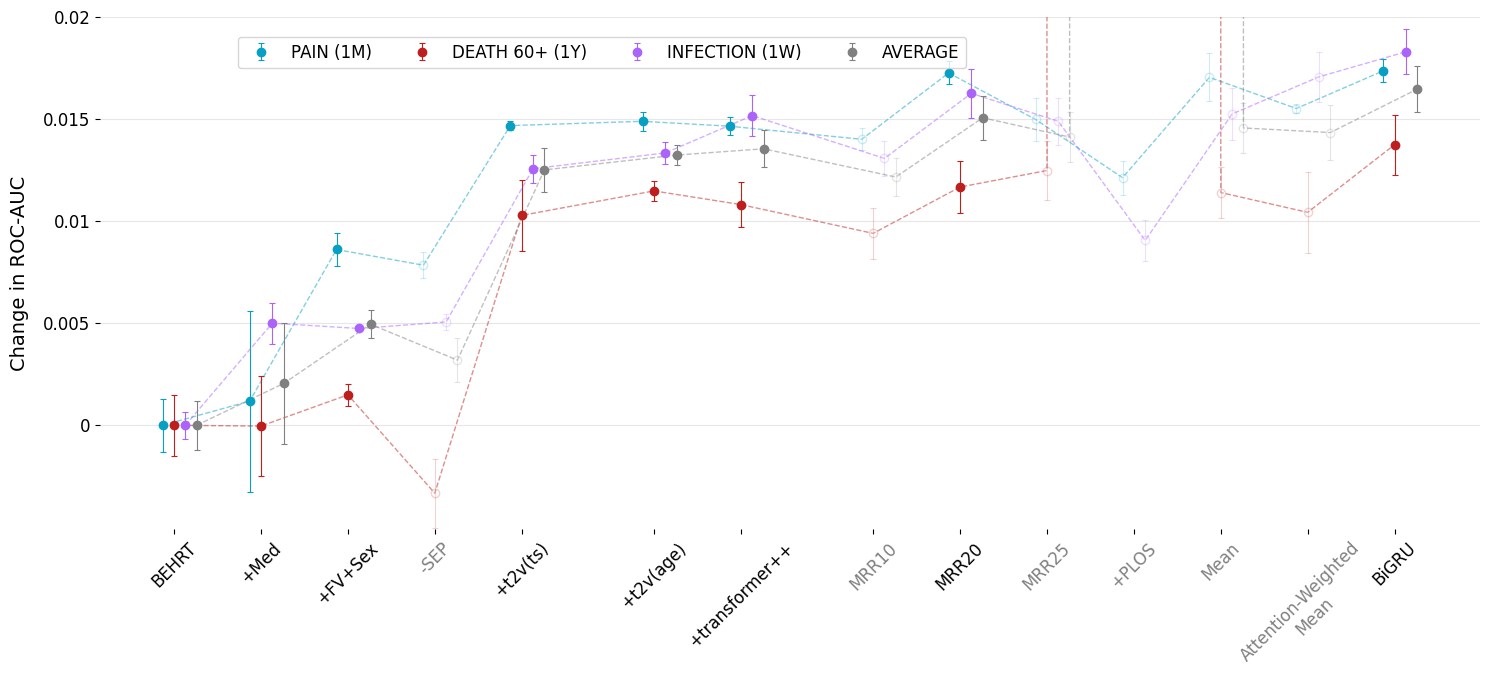

In [51]:
# Constants
FIGSIZE = (15, 7)
MODEL_DISTANCE = 0.15
GROUP_GAP = 0.6
LEGEND_LOC = (0.1, .9)
GROUP_LABEL_PAD = 0.01
Y_LIM = (-.0051, .02)
BOX_COLORS = {'Data': "#5599FF", 'Model': "#5599FF", 'Training': "#5599FF"}

def normalize_scores(scores):
    """Normalize scores by subtracting the first score from all scores."""
    return [(score - scores[0]) if score is not None else None for score in scores]

def create_scatter_plot(ax, positions, scores, stds, label, color, adapted):
    """Creates a scatter plot with error bars."""
    scores = normalize_scores(scores)
    for i, (pos, score, std, a) in enumerate(zip(positions, scores, stds, adapted)):
        if score is not None:
            ax.errorbar(pos, score, yerr=std, markersize=6, fmt='o', capsize=2, capthick=0.8,
                        elinewidth=0.8, mfc=color if a else 'w', mec=color, label=label if i == 0 else None,
                        color=color, alpha=1 if a else .2)

def set_spines_visibility(ax, visibility=False):
    """Sets the visibility of the plot spines."""
    for spine in ['right', 'top', 'bottom', 'left']:
        ax.spines[spine].set_visible(visibility)

def style_plot(ax, y_ticklabels):
    """Styles the plot."""
    set_spines_visibility(ax)
    ax.set_yticks(y_ticklabels)
    ax.set_yticklabels(y_ticklabels, color='k', fontsize=12)
    ax.legend(loc=LEGEND_LOC, frameon=True, fontsize=12, ncol=4)
    ax.grid(False)
    ax.grid(axis='y', linestyle='-', alpha=0.3)
def filter_none(positions, scores):
    """Filters out None values from the scores and positions."""
    return zip(*[(pos, score) for pos, score in zip(positions, scores) if score is not None])
def create_line_plot(ax, positions, scores, color):
    """Creates a line plot."""
    scores = normalize_scores(scores)
    positions, scores = filter_none(positions, scores)
    ax.plot(positions, scores, color=color, linestyle='--', linewidth=1, alpha=0.5)

def add_group_labels(ax, positions, labels, colors, y_position):
    """Adds group labels to the plot."""
    for pos, label in zip(positions, labels):
        ax.text(pos, y_position, label, ha='center', va='top', fontsize=14, fontweight='bold', color='white',
                bbox=dict(facecolor=colors[label], edgecolor='none', boxstyle='round,pad=1'))
def set_model_adapted_colors(ax, model_adapted):
    """Sets the colors of the x-tick labels based on model adaptation."""
    colors = ['k' if adapted else 'grey' for adapted in model_adapted]
    for xtick, color in zip(ax.get_xticklabels(), colors):
        xtick.set_color(color)
def initialize_plot(models, groups):
    """Initializes the plot with adjusted positions and group labels."""
    positions = np.arange(len(models))
    adjusted_positions = []
    group_labels = []
    group_label_positions = []
    offset = 0

    for group, indices in groups.items():
        group_size = indices.stop - indices.start
        for i in range(group_size):
            adjusted_positions.append(positions[indices.start + i] + offset)
            offset += MODEL_DISTANCE
        group_labels.append(group)
        group_label_positions.append(np.mean(adjusted_positions[-group_size:]))
        offset += GROUP_GAP  # Adding space after each group

    # Adjust the positions for plotting
    adjusted_positions = np.array(adjusted_positions) - 1.5 * MODEL_DISTANCE
    return adjusted_positions, group_labels, group_label_positions

def plot_data(ax, positions, model_adapted, scores,stds, colors):
    """Plots the data for each category."""
    for i, (category, color) in enumerate(colors.items()):
        category_scores = scores[category]
        category_stds = stds[category] 
        create_scatter_plot(ax, positions + i * MODEL_DISTANCE, category_scores, category_stds, category.upper(), color, model_adapted)
        create_line_plot(ax, positions + i * MODEL_DISTANCE, category_scores, color)

def main():
    # Your data initialization here
    fig, ax = plt.subplots(figsize=FIGSIZE)
    adjusted_positions, group_labels, group_label_positions = initialize_plot(models, groups)
    
    colors = { 'PAIN (1m)': '#07A0C3', 'DEATH 60+ (1y)': '#BD1E1E','INFECTION (1w)': '#AB63FA', 'average':'grey'}
    
    plot_data(ax, adjusted_positions, model_adapted, roc_scores, roc_stds, colors)

    # Setting the x-ticks to be the diseases with adjusted positions
    ax.set_xticks(adjusted_positions + MODEL_DISTANCE)
    ax.set_xticklabels(models, fontsize=12, rotation=45, color='k')
    set_model_adapted_colors(ax, model_adapted)

    ax.set_ylim(Y_LIM)
    y_ticklabels = [0, .005, .01, .015, .02
                    ]
    style_plot(ax, y_ticklabels)
    #add_group_labels(ax, group_label_positions, group_labels, BOX_COLORS, Y_LIM[0] - GROUP_LABEL_PAD)

    def add_annootation_with_brackets(x, y, label, width):
        ax.annotate(label, xy=(x, y), xytext=(x, y-.12), 
                xycoords='axes fraction', fontsize=13, ha='center', va='bottom', color='white', 
                bbox=dict(fc=BOX_COLORS[label], edgecolor='none', boxstyle='round,pad=1'), 
                arrowprops=dict(arrowstyle=f'-[, widthB={width}, lengthB=1.1', lw=1.0, color='k'))
    x_bracket = 0.18
    y_bracket = -.4
    #add_annootation_with_brackets(x_bracket, y_bracket, 'Data', 12.5)
    #add_annootation_with_brackets(.68, y_bracket, 'Model', 21.5)
    # to not cut off the frame
    #ax.annotate('extend',xy=(1, y_bracket-.2), xytext = (1, y_bracket-.2), color='white',xycoords='axes fraction')
    
    ax.set_ylabel('Change in ROC-AUC', fontsize=14, color='k',labelpad=10)
    plt.tight_layout()
    plt.show()
    
    #fig.savefig('roc_scores_comparison.png', dpi=300, bbox_inches='tight')

if __name__ == "__main__":
    main()


In [18]:
import seaborn as sns


['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3']

In [21]:
sns.color_palette("Set3").as_hex()

['#8dd3c7',
 '#ffffb3',
 '#bebada',
 '#fb8072',
 '#80b1d3',
 '#fdb462',
 '#b3de69',
 '#fccde5',
 '#d9d9d9',
 '#bc80bd',
 '#ccebc5',
 '#ffed6f']

## Simplify

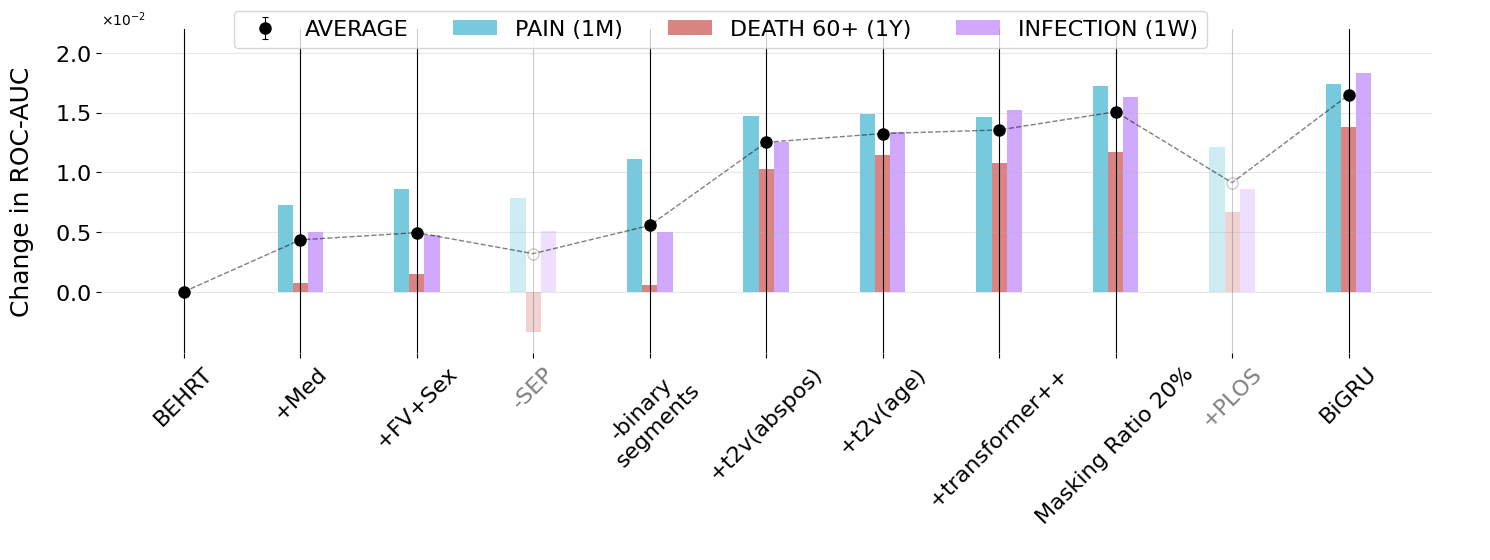

## Dead end version

In [ ]:
# Constants
from matplotlib.ticker import ScalarFormatter
FIGSIZE = (15, 7)
MODEL_DISTANCE = 0.15
GROUP_GAP = 0.0
LEGEND_LOC = (0.1, .94)
GROUP_LABEL_PAD = 0.01
Y_LIM = (-.0051, .022)
BOX_COLORS = {'Data': "#5599FF", 'Model': "#5599FF", 'Training': "#5599FF"}
FONTSIZE1 = 16
FONTSIZE2 = 18
def normalize_scores(scores):
    """Normalize scores by subtracting the first score from all scores."""
    return [(score - scores[0]) if score is not None else None for score in scores]

def create_scatter_plot(ax, positions, scores, stds, label, color, adapted):
    """Creates a scatter plot with error bars."""
    scores = normalize_scores(scores)
    for i, (pos, score, std, a) in enumerate(zip(positions, scores, stds, adapted)):
        if score is not None:
            ax.errorbar(pos, score, yerr=std, markersize=8, fmt='o', capsize=2, capthick=0.8,
                        elinewidth=0.8, mfc=color if a else 'w', mec=color, label=label if i == 0 else None,
                        color=color, alpha=1 if a else .2)

def set_spines_visibility(ax, visibility=False):
    """Sets the visibility of the plot spines."""
    for spine in ['right', 'top', 'bottom', 'left']:
        ax.spines[spine].set_visible(visibility)

def style_plot(ax, y_ticks):
    """Styles the plot and uses scientific notation for the y-axis."""
    set_spines_visibility(ax)

    # Scale y-ticks (assuming your y-values are already scaled by 1e-2)
    ax.set_yticks(y_ticks)

    # Use scientific notation for y-axis
    ax.tick_params(axis='y', which='major', labelsize=FONTSIZE1)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(-3, -3))

    ax.legend(loc=LEGEND_LOC, frameon=True, fontsize=FONTSIZE1, ncol=4)
    ax.grid(False)
    ax.grid(axis='y', linestyle='-', alpha=0.3)
def filter_none(positions, scores):
    """Filters out None values from the scores and positions."""
    return zip(*[(pos, score) for pos, score in zip(positions, scores) if score is not None])
def create_line_plot(ax, positions, scores, color):
    """Creates a line plot."""
    scores = normalize_scores(scores)
    positions, scores = filter_none(positions, scores)
    ax.plot(positions, scores, color=color, linestyle='--', linewidth=1, alpha=0.5)

def add_group_labels(ax, positions, labels, colors, y_position):
    """Adds group labels to the plot."""
    for pos, label in zip(positions, labels):
        ax.text(pos, y_position, label, ha='center', va='top', fontsize=16, fontweight='bold', color='white',
                bbox=dict(facecolor=colors[label], edgecolor='none', boxstyle='round,pad=1'))
def set_model_adapted_colors(ax, model_adapted):
    """Sets the colors of the x-tick labels based on model adaptation."""
    colors = ['k' if adapted else 'grey' for adapted in model_adapted]
    for xtick, color in zip(ax.get_xticklabels(), colors):
        xtick.set_color(color)
def initialize_plot(models, groups):
    """Initializes the plot with adjusted positions and group labels."""
    positions = np.arange(len(models))
    adjusted_positions = []
    group_labels = []
    group_label_positions = []
    offset = 0

    for group, indices in groups.items():
        group_size = indices.stop - indices.start
        for i in range(group_size):
            adjusted_positions.append(positions[indices.start + i] + offset)
            offset += MODEL_DISTANCE
        group_labels.append(group)
        group_label_positions.append(np.mean(adjusted_positions[-group_size:]))
        offset += GROUP_GAP  # Adding space after each group

    # Adjust the positions for plotting
    adjusted_positions = np.array(adjusted_positions) - 1.5 * MODEL_DISTANCE
    return adjusted_positions, group_labels, group_label_positions

def plot_data(ax, positions, model_adapted, scores,stds, colors):
    """Plots the data for each category."""
    for i, (category, color) in enumerate(colors.items()):
        category_scores = scores[category]
        category_stds = stds[category] 
        if category != 'average':
            create_bar_plot(ax, positions + i * MODEL_DISTANCE, category_scores, category_stds, category.upper(), color, model_adapted)
        else:
            create_scatter_plot(ax, positions+2*MODEL_DISTANCE , category_scores, category_stds, category.upper(), color, model_adapted)
            create_line_plot(ax, positions+2*MODEL_DISTANCE , category_scores, color)

def create_bar_plot(ax, positions, scores, stds, label, color, adapted):
    """Creates a scatter plot with error bars."""
    scores = normalize_scores(scores)
    for i, (pos, score, std, a) in enumerate(zip(positions, scores, stds, adapted)):
        if score is not None:
            ax.bar(pos, score, color=color, alpha=.55 if a else .2, width=MODEL_DISTANCE, label=label if i == 0 else None)

def main():
    # Your data initialization here
    fig, ax = plt.subplots(figsize=FIGSIZE)
    adjusted_positions, group_labels, group_label_positions = initialize_plot(models, groups)
    
    colors = { 'average':'k','PAIN (1m)': '#07A0C3', 'DEATH 60+ (1y)': '#BD1E1E','INFECTION (1w)': '#AB63FA', }
    
    plot_data(ax, adjusted_positions, model_adapted, roc_scores, roc_stds, colors)

    # Setting the x-ticks to be the diseases with adjusted positions
    ax.set_xticks(adjusted_positions + MODEL_DISTANCE)
    ax.set_xticklabels(models, fontsize=FONTSIZE1, rotation=45, color='k')
    set_model_adapted_colors(ax, model_adapted)

    ax.set_ylim(Y_LIM)
    y_ticklabels = [0, .005, .01, .015,.02
                    ]
    style_plot(ax, y_ticklabels)
    #add_group_labels(ax, group_label_positions, group_labels, BOX_COLORS, Y_LIM[0] - GROUP_LABEL_PAD)

    def add_annootation_with_brackets(x, y, label, width):
        ax.annotate(label, xy=(x, y), xytext=(x, y-.12), 
                xycoords='axes fraction', fontsize=17, ha='center', va='bottom', color='white', 
                bbox=dict(fc=BOX_COLORS[label], edgecolor='none', boxstyle='round,pad=1'), 
                arrowprops=dict(arrowstyle=f'-[, widthB={width}, lengthB=1.1', lw=1.0, color='k'))
    x_bracket = 0.18
    y_bracket = -.4
    #add_annootation_with_brackets(x_bracket, y_bracket, 'Data', 12.5)
    #add_annootation_with_brackets(.68, y_bracket, 'Model', 21.5)
    # to not cut off the frame
    #ax.annotate('extend',xy=(1, y_bracket-.2), xytext = (1, y_bracket-.2), color='white',xycoords='axes fraction')
    
    ax.set_ylabel('Change in ROC-AUC', fontsize=FONTSIZE2, color='k',labelpad=15)
    plt.tight_layout()
    plt.show()
    
    fig.savefig('roc_scores_comparison.png', dpi=300, bbox_inches='tight')

if __name__ == "__main__":
    main()


## Real Data

In [5]:
roc_scores = {'DEATH 60+ (1y)': [0.8586, 0.86149, 0.86326, None, 0.86228, 0.86448, 0.86639, 0.87056, 0.86767, 0.86711, 0.86775], 'INFECTION (1w)': [0.73762, None, 0.74215, None, None, None, 0.74991, 0.75405, 0.75099, None, 0.74022], 'PAIN (1m)': [0.7738, 0.77705, 0.77913, 0.77821, 0.77904, 0.78135, None, 0.78473, 0.78661, 0.78565, None]}
roc_stds = {'DEATH 60+ (1y)': [0.0003, 0.00072, 0.00073, None, 0.00045, 0.0006, 0.00087, 0.00053, 0.00063, 0.00051, 0.00068], 'INFECTION (1w)': [0.00073, None, 0.00036, None, None, None, 0.00075, 0.00094, 0.00094, None, 0.00102], 'PAIN (1m)': [0.00089, 0.00045, 0.00062, 0.00032, 0.00047, 0.00058, None, 0.00038, 0.00044, 0.00046, None]}
models = ['001_diag', '001', '111', '110', 
    '111_posirang', '111_++', '111_time2vec_abspos', '111_Abspos++', 
    '111_time2vec_AgeAbspos', '111_11', '111_time2vec_AgeAbspos_++']
model_map = {'001_diag':'BEHRT', '001':'+Med', '111':'+FV+Sex', '110':'-SEP',
                '111_posirang':'+pos_ids', '111_++':'transformer++',
                '111_time2vec_abspos':'+t2v(ts)',
                '111_Abspos++':'t2v(ts)+RoPE(pos_ids)+SwiGLU',
                '111_time2vec_AgeAbspos':'+t2v(age)',
                '111_11':'trainable embedding weights',
                '111_time2vec_AgeAbspos_++':'+RoPE(pos_ids)+SwiGLU',
             }

models = [model_map[model] for model in models]
models = {
    'Data': ['BEHRT', '+Med', '+FV+Sex','-SEP', ],
    'Model': ['+pos_ids',
                'transformer++', 
                '+t2v(ts)',
                't2v(ts)+RoPE(pos_ids)+SwiGLU',
                '+t2v(age)', 
                'trainable\nembedding\nweights',
                '+RoPE(pos_ids)\n+SwiGLU'], 
}
#Specify which models should be hatched
groups = {
    'Data': slice(0, len(models['Data'])),
    'Model': slice(len(models['Data']), len(models['Data']) + len(models['Model'])),}
    #'Training': slice(len(models['Data'])+len(models['Model']), len(models['Data'])+len(models['Model'])+len(models['Training']))}
models = [model for group in models.values() for model in group]
model_adapted = [True] * 3 + [False]*3 + [True]+[False]+ [True] + [False] + [True]
assert len(model_adapted) == len(models) 
for key in roc_scores.keys():
    assert len(roc_scores[key]) == len(models)
    assert len(roc_stds[key]) == len(models)

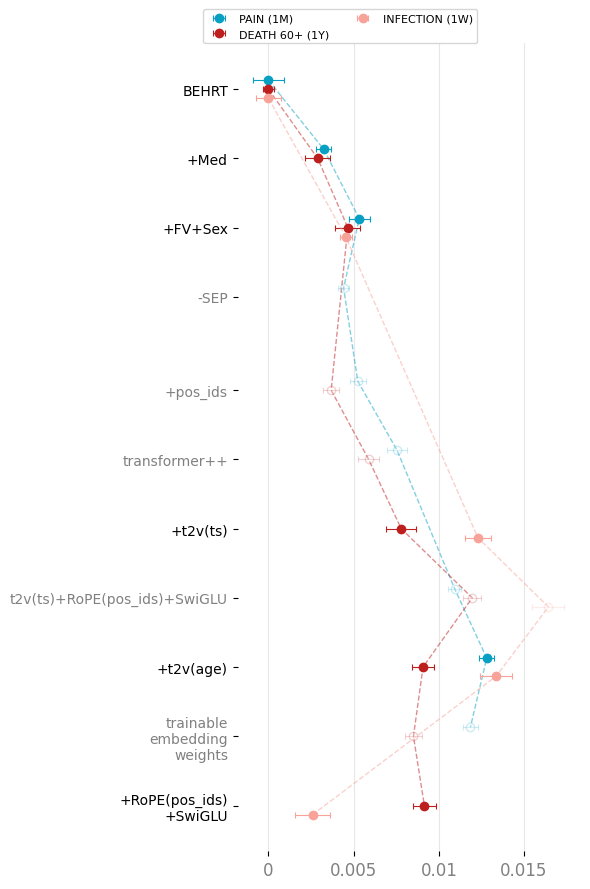

In [14]:
# Constants
FIGSIZE = (6, 9)
MODEL_DISTANCE = 0.15
GROUP_GAP = 0.4
DISEASE_GAP = 0.05
LEGEND_LOC = (-.1, 1)
GROUP_LABEL_PAD = 0.01
#Y_LIM = (-.0051, .02)
BOX_COLORS = {'Data': "#5599FF", 'Model': "#5599FF", 'Training': "#5599FF"}

def set_model_adapted_colors(ax, model_adapted):
    """Sets the colors of the x-tick labels based on model adaptation."""
    colors = ['black' if adapted else 'grey' for adapted in model_adapted]
    for ytick, color in zip(ax.get_yticklabels(), colors):
        ytick.set_color(color)

def add_group_labels(ax, positions, labels, colors, x_position):
    """Adds group labels to the plot."""
    for pos, label in zip(positions, labels):
        ax.text(x_position, pos, label, ha='center', va='top', fontsize=14, fontweight='bold', color='white',
                bbox=dict(facecolor=colors[label], edgecolor='none', boxstyle='round,pad=1', ),
                rotation=90)

def style_plot(ax, y_ticklabels):
    """Styles the plot."""
    set_spines_visibility(ax)
    ax.set_xticks(y_ticklabels)
    ax.set_xticklabels(y_ticklabels, color='grey', fontsize=12)
    ax.legend(loc=LEGEND_LOC, frameon=True, fontsize=8, ncol=2)
    ax.grid(False)
    ax.grid(axis='x', linestyle='-', alpha=0.3)

def create_scatter_plot(ax, positions, scores, stds, label, color, adapted):
    """Creates a scatter plot with error bars."""
    scores = normalize_scores(scores)
    for i, (pos, score, std, ad) in enumerate(zip(positions, scores, stds, adapted)):
        if score is not None:
            ax.errorbar(score, pos, xerr=std, markersize=6, fmt='o', capsize=2, capthick=0.8,
                        elinewidth=0.8, mfc=color if ad else 'w', mec=color, label=label if i == 0 else None,
                        color=color, alpha=1 if ad else .2)
def filter_none(positions, scores):
    """Filters out None values from the scores and positions."""
    return zip(*[(pos, score) for pos, score in zip(positions, scores) if score is not None])

def create_line_plot(ax, positions, scores, color):
    """Creates a line plot."""
    scores = normalize_scores(scores)
    positions, scores = filter_none(positions, scores)
    ax.plot(scores, positions, color=color, linestyle='--', linewidth=1, alpha=0.5)

def plot_data(ax, positions, model_adapted, scores,stds, colors):
    """Plots the data for each category."""
    for i, (category, color) in enumerate(colors.items()):
        category_scores = scores[category]
        category_stds = stds[category] 
        create_scatter_plot(ax, positions + i * MODEL_DISTANCE, category_scores, category_stds, category.upper(), color, model_adapted)
        create_line_plot(ax, positions + i * MODEL_DISTANCE, category_scores, color)

# ... existing code ...

def main():
    # Your data initialization here
    fig, ax = plt.subplots(figsize=FIGSIZE)
    adjusted_positions, group_labels, group_label_positions = initialize_plot(models, groups)
    
    colors = { 'PAIN (1m)': '#07A0C3', 'DEATH 60+ (1y)': '#BD1E1E','INFECTION (1w)': '#F7A399'}
    
    plot_data(ax, adjusted_positions, model_adapted, roc_scores, roc_stds, colors)
    ax.set_yticks(adjusted_positions +  MODEL_DISTANCE)
    ax.set_yticklabels(models, fontsize=10, color='k')
   
    set_model_adapted_colors(ax, model_adapted)
    
    x_ticklabels = [ 0, .005, .01, .015]
    ax.set_ylim(ax.get_ylim()[::-1])
    style_plot(ax, x_ticklabels)
    #add_group_labels(ax, group_label_positions, group_labels, BOX_COLORS, -.01)

    plt.tight_layout()
    plt.show()
    fig.savefig('roc_scores_comparison.png', dpi=300, bbox_inches='tight')

if __name__ == "__main__":
    main()

## Vertical

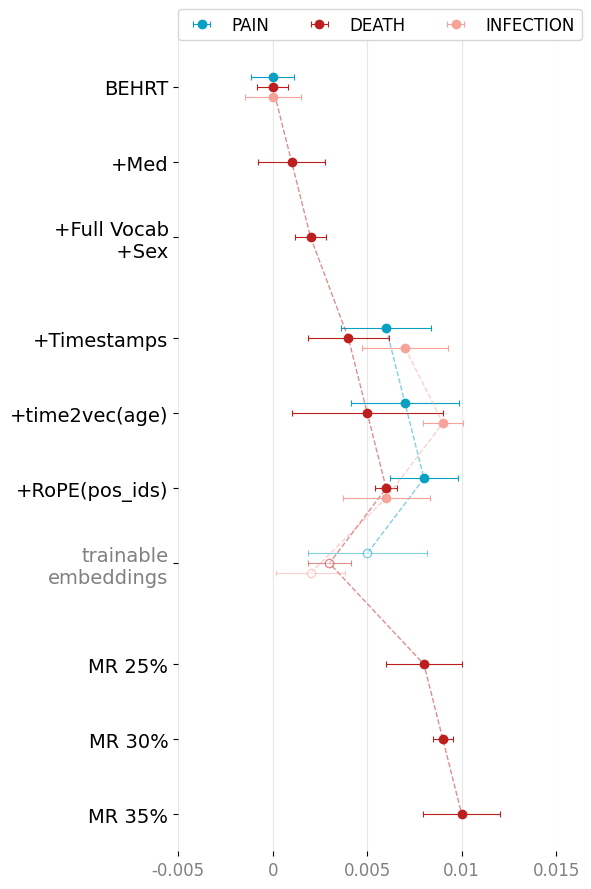

In [52]:
# Constants
FIGSIZE = (6, 9)
MODEL_DISTANCE = 0.15
GROUP_GAP = 0.4
DISEASE_GAP = 0.05
LEGEND_LOC = (0, 1)
GROUP_LABEL_PAD = 0.01
#Y_LIM = (-.0051, .02)
BOX_COLORS = {'Data': "#5599FF", 'Model': "#5599FF", 'Training': "#5599FF"}

def set_model_adapted_colors(ax, model_adapted):
    """Sets the colors of the x-tick labels based on model adaptation."""
    colors = ['grey' if adapted else 'black' for adapted in model_adapted]
    for ytick, color in zip(ax.get_yticklabels(), colors):
        ytick.set_color(color)

def add_group_labels(ax, positions, labels, colors, y_position):
    """Adds group labels to the plot."""
    for pos, label in zip(positions, labels):
        ax.text(pos, y_position, label, ha='center', va='top', fontsize=14, fontweight='bold', color='white',
                bbox=dict(facecolor=colors[label], edgecolor='none', boxstyle='round,pad=1'))

def style_plot(ax, y_ticklabels):
    """Styles the plot."""
    set_spines_visibility(ax)
    ax.set_xticks(y_ticklabels)
    ax.set_xticklabels(y_ticklabels, color='grey', fontsize=12)
    ax.legend(loc=LEGEND_LOC, frameon=True, fontsize=12, ncol=4)
    ax.grid(False)
    ax.grid(axis='x', linestyle='-', alpha=0.3)

def create_scatter_plot(ax, positions, scores, stds, label, color, faint):
    """Creates a scatter plot with error bars."""
    scores = normalize_scores(scores)
    for i, (pos, score, std, f) in enumerate(zip(positions, scores, stds, faint)):
        if score is not None:
            ax.errorbar(score, pos, xerr=std, markersize=6, fmt='o', capsize=2, capthick=0.8,
                        elinewidth=0.8, mfc='w' if f else color, mec=color, label=label if i == 4 else None,
                        color=color, alpha=0.5 if f else 1)

def create_line_plot(ax, positions, scores, color):
    """Creates a line plot."""
    scores = normalize_scores(scores)
    ax.plot(scores, positions, color=color, linestyle='--', linewidth=1, alpha=0.5)

def plot_data(ax, positions, model_adapted, scores,stds, colors):
    """Plots the data for each category."""
    for i, (category, color) in enumerate(colors.items()):
        category_scores = scores[category]
        category_stds = stds[category] 
        create_scatter_plot(ax, positions + i * MODEL_DISTANCE, category_scores, category_stds, category.upper(), color, model_adapted)
        create_line_plot(ax, positions + i * MODEL_DISTANCE, category_scores, color)

# ... existing code ...

def main():
    # Your data initialization here
    fig, ax = plt.subplots(figsize=FIGSIZE)
    adjusted_positions, group_labels, group_label_positions = initialize_plot(models, groups)
    
    colors = { 'pain': '#07A0C3', 'death': '#BD1E1E','infection': '#F7A399'}
    
    plot_data(ax, adjusted_positions, model_adapted, roc_scores, roc_stds, colors)
    ax.set_yticks(adjusted_positions +  MODEL_DISTANCE)
    ax.set_yticklabels(models, fontsize=14, color='k')
   
    set_model_adapted_colors(ax, model_adapted)
    
    x_ticklabels = [-.005, 0, .005, .01, .015]
    ax.set_ylim(ax.get_ylim()[::-1])
    style_plot(ax, x_ticklabels)
    #add_group_labels(ax, group_label_positions, group_labels, BOX_COLORS, Y_LIM[0] - GROUP_LABEL_PAD)
    plt.tight_layout()
    plt.show()
    #fig.savefig('roc_scores_comparison.png', dpi=300, bbox_inches='tight')

if __name__ == "__main__":
    main()